## **Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class params:

    data_path = '/content/drive/MyDrive/Project'
    bad_images = '/content/drive/MyDrive/Project/Bad'
    good_images = '/content/drive/MyDrive/Project/Good'
    csv_files = '/content/drive/MyDrive/Project/csv_files'

In [ ]:
import os
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

## **Dataset**



In [ ]:
all_images = os.listdir(params.bad_images) + os.listdir(params.good_images)

In [ ]:
dataset = pd.DataFrame(
    {
        'images': [f"{params.bad_images}/{x}" for x in os.listdir(params.bad_images)] + [f"{params.good_images}/{x}" for x in os.listdir(params.good_images)],
        'label': [0]*len(os.listdir(params.bad_images)) + [1]*len(os.listdir(params.good_images))
    }
)

In [ ]:
dataset.head()

,images,label
0,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
1,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
2,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
3,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
4,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0


In [ ]:
dataset['label'].value_counts(normalize = True)

label
1    0.773626
0    0.226374
Name: proportion, dtype: float64

In [ ]:
X = dataset['images']
y = dataset['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((364,), (91,), (364,), (91,))

In [ ]:
y_train.value_counts(normalize = True)

label
1    0.774725
0    0.225275
Name: proportion, dtype: float64

In [ ]:
y_test.value_counts(normalize = True)

label
1    0.769231
0    0.230769
Name: proportion, dtype: float64

## **Feature Extration**

In [ ]:
import cv2
import numpy as np
from skimage.feature import greycomatrix, graycoprops, graycomatrix
from skimage import io, color, img_as_ubyte
from skimage.feature import local_binary_pattern
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy

In [ ]:
def ExtractFeatures(image_ids):
  """
  image_paths: Paths to the images
  """
  import time
  from tqdm import tqdm
  import warnings
  warnings.filterwarnings("ignore")

  features = {"image_id": [],
                "average_hue":[],
                "average_saturation": [],
                "average_value" : [],
                "area": [],
                "x":[], "y":[],
                "w":[], "h":[],
                "aspect_ratio": [],
                "correlation": [],
                "energy":[],
                "contrast":[],
                "homogeneity":[]}

  for image_id in tqdm(image_ids, desc="Processing", unit="images"):

    features["image_id"].append(image_id)
    image = cv2.imread(image_id)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Color Features
    average_color = np.mean(image, axis=(0, 1))
    color_histogram = cv2.calcHist([image], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    dominant_color = np.argmax(color_histogram)
    color_variance = np.var(image)

    # 1. Average color in HSV channels (Hue, Saturation, Value)
    h, s, v,_ = cv2.mean(hsv)
    features["average_hue"].append(h)
    features["average_saturation"].append(s)
    features["average_value"].append(v)

    # 3. Area of the tomato (assuming some segmentation is done beforehand)
    # Replace this with your segmentation method (e.g., Otsu's thresholding)
    # This is a placeholder for demonstration purposes
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        largest_area = cv2.contourArea(contours[0])
        for cnt in contours:
          area = cv2.contourArea(cnt)
          if area > largest_area:
            largest_area = area
    else:
        largest_area = 0
    features["area"].append(largest_area)
    cnt = max(contours, key=cv2.contourArea)

    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    (x, y, w, h) = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h

    features["w"].append(w)
    features["h"].append(h)
    features["x"].append(x)
    features["y"].append(y)
    features["aspect_ratio"].append(aspect_ratio)

    glcm = graycomatrix(gray_image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')

    features["correlation"].append(correlation.mean())
    features["energy"].append(energy.mean())
    features["contrast"].append(contrast.mean())
    features["homogeneity"].append(homogeneity.mean())

  return pd.DataFrame(features)

In [ ]:
## Extracting Training Dataset
features_df = ExtractFeatures(image_ids = X_train.values)

Processing:   6%|▌         | 22/364 [02:16<35:27,  6.22s/images]


KeyboardInterrupt: 

In [ ]:
features_df["quality"] = y_train.values
features_df.head()

,image_id,average_hue,average_saturation,average_value,area,x,y,w,h,aspect_ratio,correlation,energy,contrast,homogeneity,quality
0,/content/drive/MyDrive/Project/Bad/IMG_2024021...,171.740116,0.0,0.0,10423027.5,672,1979,3593,4089,0.878699,0.999776,0.102137,1.368497,0.761298,0
1,/content/drive/MyDrive/Project/Good/IMG_202402...,181.174462,0.0,0.0,10067058.5,1631,2906,3162,4217,0.749822,0.999882,0.111418,0.615052,0.777823,1
2,/content/drive/MyDrive/Project/Good/IMG_202402...,172.587475,0.0,0.0,14213498.0,1684,1716,3660,5086,0.719622,0.999803,0.106929,1.268606,0.764490,1
3,/content/drive/MyDrive/Project/Good/IMG_202402...,179.551992,0.0,0.0,11838790.0,994,2563,4087,4166,0.981037,0.999852,0.122994,0.700893,0.787451,1
4,/content/drive/MyDrive/Project/Bad/IMG_2024021...,193.934136,0.0,0.0,7494464.0,812,3247,3815,2973,1.283216,0.999512,0.183497,1.646527,0.747916,0


In [ ]:
## Saving Training Dataset
features_df.to_csv(f"{params.csv_files}/Train.csv", index = False)

In [ ]:
# ## Extracting Testing Dataset
features_test = ExtractFeatures(image_ids = X_test.values)

Processing: 100%|██████████| 91/91 [07:18<00:00,  4.81s/images]


In [ ]:
features_test["quality"] = y_test.values
features_test.head()

NameError: name 'features_test' is not defined

In [ ]:
# ## Saving Testing Dataset
features_test.to_csv(f"{params.csv_files}/Test.csv", index = False)

## **Reading CSV Files**

In [ ]:
train_df = pd.read_csv(f"{params.csv_files}/Train.csv")
test_df = pd.read_csv(f"{params.csv_files}/Test.csv")

In [ ]:
train_df.shape, test_df.shape

((364, 15), (91, 15))

In [ ]:
train_df.head()

,image_id,average_hue,average_saturation,average_value,area,x,y,w,h,aspect_ratio,correlation,energy,contrast,homogeneity,quality
0,/content/drive/MyDrive/Project/Bad/IMG_2024021...,171.740116,0.0,0.0,10423027.5,672,1979,3593,4089,0.878699,0.999776,0.102137,1.368497,0.761298,0
1,/content/drive/MyDrive/Project/Good/IMG_202402...,181.174462,0.0,0.0,10067058.5,1631,2906,3162,4217,0.749822,0.999882,0.111418,0.615052,0.777823,1
2,/content/drive/MyDrive/Project/Good/IMG_202402...,172.587475,0.0,0.0,14213498.0,1684,1716,3660,5086,0.719622,0.999803,0.106929,1.268606,0.764490,1
3,/content/drive/MyDrive/Project/Good/IMG_202402...,179.551992,0.0,0.0,11838790.0,994,2563,4087,4166,0.981037,0.999852,0.122994,0.700893,0.787451,1
4,/content/drive/MyDrive/Project/Bad/IMG_2024021...,193.934136,0.0,0.0,7494464.0,812,3247,3815,2973,1.283216,0.999512,0.183497,1.646527,0.747916,0


## **Exploratory Data Analysis**

In [ ]:
test_df['quality'].value_counts()

quality
1    70
0    21
Name: count, dtype: int64

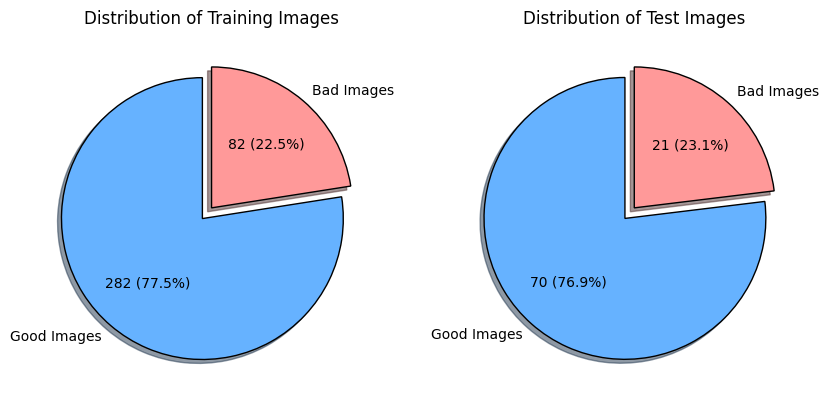

In [ ]:
import matplotlib.pyplot as plt

# Sample data
labels = ['Good Images', 'Bad Images']
counts_train = [282, 82]  # Replace with your actual counts
counts_test = [70, 21]  # Replace with your actual counts

# Calculate percentages
total_count_train = sum(counts_train)
percentages_train = [(count / total_count_train) * 100 for count in counts_train]

total_count_test = sum(counts_test)
percentages_test = [(count / total_count_test) * 100 for count in counts_test]

# Define pleasing colors
colors = ['#66b2ff', '#ff9999']

# Plotting the 2D pie chart with shadow
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Define the amount of explosion (0.1 means 10% of the radius)
explode = (0.1, 0)

ax[0].pie(counts_train, labels=labels, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * total_count_train / 100, p),
          startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, shadow=True, explode=explode)
# Add a title
ax[0].set_title('Distribution of Training Images')

ax[1].pie(counts_test, labels=labels, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * total_count_test / 100, p),
          startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, shadow=True, explode=explode)
# Add a title
ax[1].set_title('Distribution of Test Images')

# Display the 2D pie chart with shadow
plt.show()


In [ ]:
train_df.describe()

,average_hue,average_saturation,average_value,area,x,y,w,h,aspect_ratio,correlation,energy,contrast,homogeneity,quality
count,364.000000,364.0,364.0,3.640000e+02,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,182.573969,0.0,0.0,9.632147e+06,1075.579670,2406.293956,3599.821429,3789.296703,0.992819,0.999776,0.119920,0.933201,0.773260,0.774725
std,8.917801,0.0,0.0,3.830468e+06,501.503274,852.480667,767.194448,921.326693,0.273242,0.000137,0.023284,0.419120,0.034102,0.418338
min,153.329184,0.0,0.0,3.485920e+05,0.000000,0.000000,1365.000000,523.000000,0.506397,0.998691,0.069446,0.457268,0.574712,0.000000
25%,176.869125,0.0,0.0,7.216668e+06,781.750000,1909.500000,3128.500000,3254.000000,0.845021,0.999740,0.104189,0.641230,0.768292,1.000000
50%,183.058745,0.0,0.0,9.530956e+06,1044.500000,2360.000000,3583.000000,3860.500000,0.931086,0.999817,0.117104,0.780416,0.779532,1.000000
75%,189.871299,0.0,0.0,1.215214e+07,1338.250000,2776.500000,4073.250000,4289.000000,1.055437,0.999859,0.133391,1.073806,0.787944,1.000000
max,203.659817,0.0,0.0,2.180006e+07,3715.000000,5921.000000,5925.000000,7034.000000,3.001815,0.999924,0.212524,2.754430,0.809252,1.000000


In [ ]:
import seaborn as sns

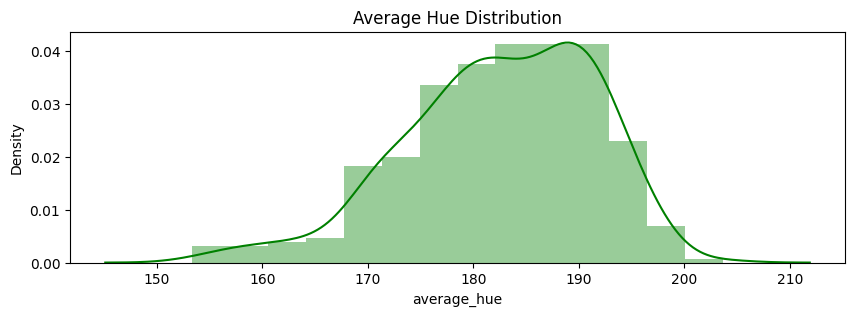

In [ ]:
plt.figure(figsize=(10,3))
sns.distplot(train_df["average_hue"], color = "green")
plt.title("Average Hue Distribution")
plt.show()

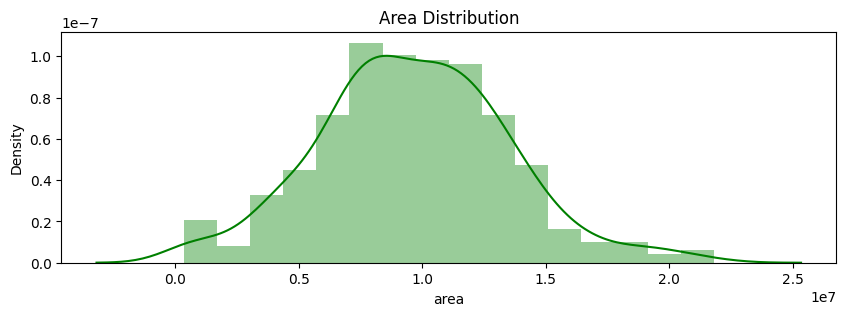

In [ ]:
plt.figure(figsize=(10,3))
sns.distplot(train_df["area"], color = "green")
plt.title("Area Distribution")
plt.show()

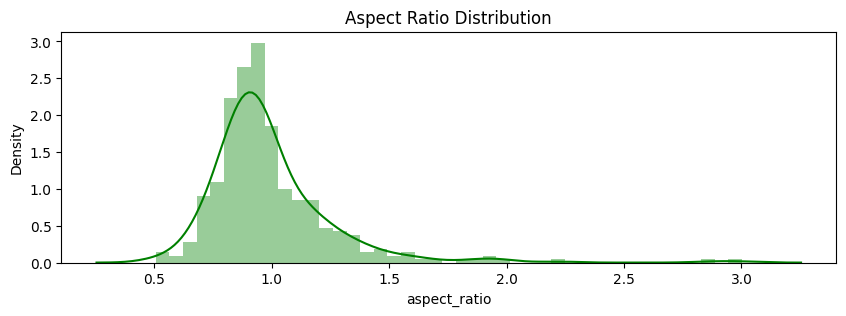

In [ ]:
plt.figure(figsize=(10,3))
sns.distplot(train_df["aspect_ratio"], color = "green")
plt.title("Aspect Ratio Distribution")
plt.show()

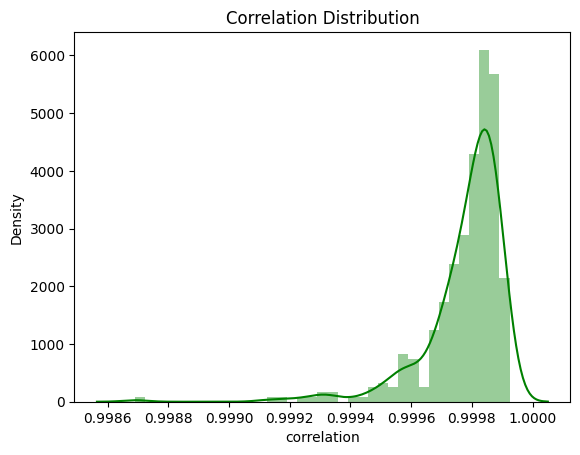

In [ ]:
sns.distplot(train_df["correlation"], color = "green")
plt.title("Correlation Distribution")
plt.show()

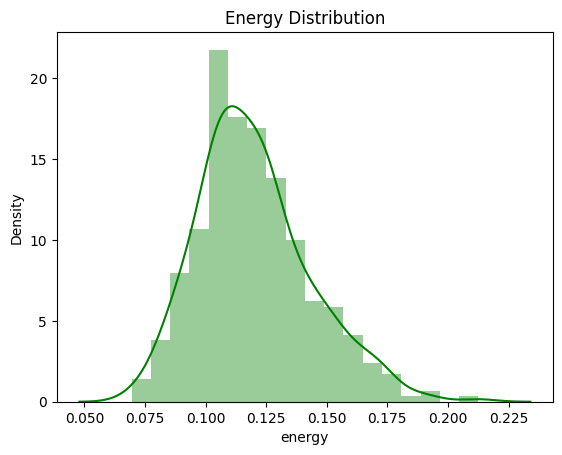

In [ ]:
sns.distplot(train_df["energy"], color = "green")
plt.title("Energy Distribution")
plt.show()

In [1]:
sns.distplot(train_df["contrast"], color = "green")
plt.title("Contrast Distribution")
plt.show()

NameError: name 'sns' is not defined

In [ ]:
sns.distplot(train_df["homogeneity"], color = "green")
plt.title("Homogeneity Distribution")
plt.show()

## **Feature Engineering and Selection**

In [ ]:
train_df.columns

Index(['image_id', 'average_hue', 'average_saturation', 'average_value',
       'area', 'x', 'y', 'w', 'h', 'aspect_ratio', 'correlation', 'energy',
       'contrast', 'homogeneity', 'quality'],
      dtype='object')

In [ ]:
features = ['average_hue', 'area', 'aspect_ratio', 'correlation', 'energy', 'contrast', 'homogeneity', 'x', 'y', 'w', 'h']
target = ["quality"]

In [ ]:
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [ ]:
X_train.head(3)

,average_hue,area,aspect_ratio,correlation,energy,contrast,homogeneity,x,y,w,h
0,171.740116,10423027.5,0.878699,0.999776,0.102137,1.368497,0.761298,672,1979,3593,4089
1,181.174462,10067058.5,0.749822,0.999882,0.111418,0.615052,0.777823,1631,2906,3162,4217
2,172.587475,14213498.0,0.719622,0.999803,0.106929,1.268606,0.764490,1684,1716,3660,5086


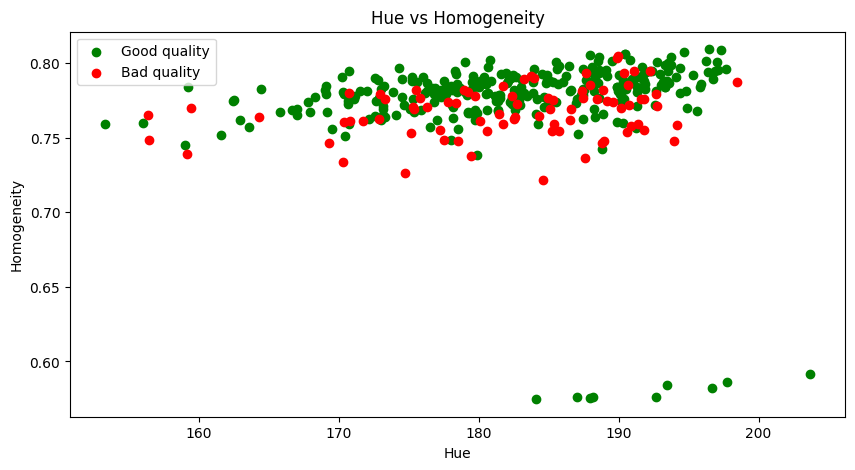

In [ ]:
plt.figure(figsize = (10,5))

plt.scatter(train_df[train_df['quality'].eq(1)]['average_hue'], train_df[train_df['quality'].eq(1)]['homogeneity'],  color = 'g', label = 'Good quality')
plt.scatter(train_df[train_df['quality'].eq(0)]['average_hue'], train_df[train_df['quality'].eq(0)]['homogeneity'],  color = 'r', label = 'Bad quality')

plt.xlabel('Hue')
plt.ylabel('Homogeneity')
plt.title('Hue vs Homogeneity')
plt.legend()

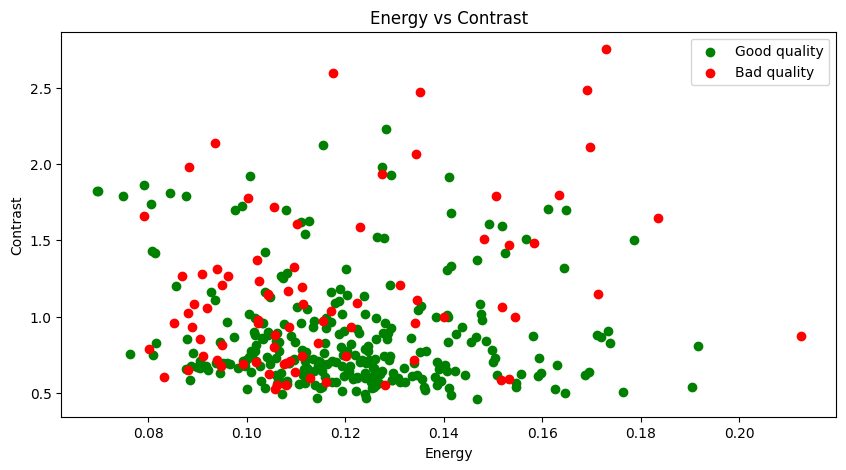

In [ ]:
plt.figure(figsize = (10,5))

plt.scatter(train_df[train_df['quality'].eq(1)]['energy'], train_df[train_df['quality'].eq(1)]['contrast'],  color = 'g', label = 'Good quality')
plt.scatter(train_df[train_df['quality'].eq(0)]['energy'], train_df[train_df['quality'].eq(0)]['contrast'],  color = 'r', label = 'Bad quality')

plt.xlabel('Energy')
plt.ylabel('Contrast')
plt.title('Energy vs Contrast')
plt.legend()

**Feature Scaling (Standardization)**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()
scaler.fit(X_train)
# Fit the scaler to the data and transform the data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import joblib
model_name = "scaler.joblib"

# Saving it with Joblib's gentle hand,
joblib.dump(scaler, model_name)

['scaler.joblib']

In [ ]:
X_train

array([[-1.21652923,  0.20675525, -0.41822639, ..., -0.50192588,
        -0.00890363,  0.32574312],
       [-0.15715016,  0.11369638, -0.89053367, ...,  0.58698559,
        -0.57146409,  0.46486444],
       [-1.12137962,  1.19767548, -1.00120927, ..., -0.81086193,
         0.07854776,  1.40936778],
       ...,
       [ 1.49253801, -2.39021749,  0.79106622, ...,  2.56159206,
        -2.77080135, -2.79035711],
       [ 1.48789435, -1.23136811, -0.41106763, ...,  0.009052  ,
        -1.5973864 , -1.18611437],
       [-2.98208895,  2.40025849,  0.13973898, ..., -0.42087422,
         1.86673296,  1.18438252]])

## **Modeling**

**Logistics Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model_log_reg = LogisticRegression()

# Train the model on the training data
model_log_reg.fit(X_train, y_train)

# Make predictions on the test data
pred_log_reg = model_log_reg.predict(X_test)

**SVC**

In [ ]:
from sklearn.svm import SVC

In [ ]:
model_svc = SVC()

# Train the model on the training data
model_svc.fit(X_train, y_train)

# Make predictions on the test data
pred_svc = model_svc.predict(X_test)

## **Model Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

**Models Accuracy**

In [ ]:
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, pred_log_reg)}")
print(f"Support Vector Classifier Accuracy: {accuracy_score(y_test, pred_svc)}")

Logistic Regression Accuracy: 0.8021978021978022
Support Vector Classifier Accuracy: 0.8351648351648352


**Logistic Regression**

In [ ]:
## Logistic Regression
print(classification_report(y_test, pred_log_reg))

              precision    recall  f1-score   support

           0       0.64      0.33      0.44        21
           1       0.82      0.94      0.88        70

    accuracy                           0.80        91
   macro avg       0.73      0.64      0.66        91
weighted avg       0.78      0.80      0.78        91



In [ ]:
## Logistic Regression
confusion_matrix(y_test, pred_log_reg)

array([[ 7, 14],
       [ 4, 66]])

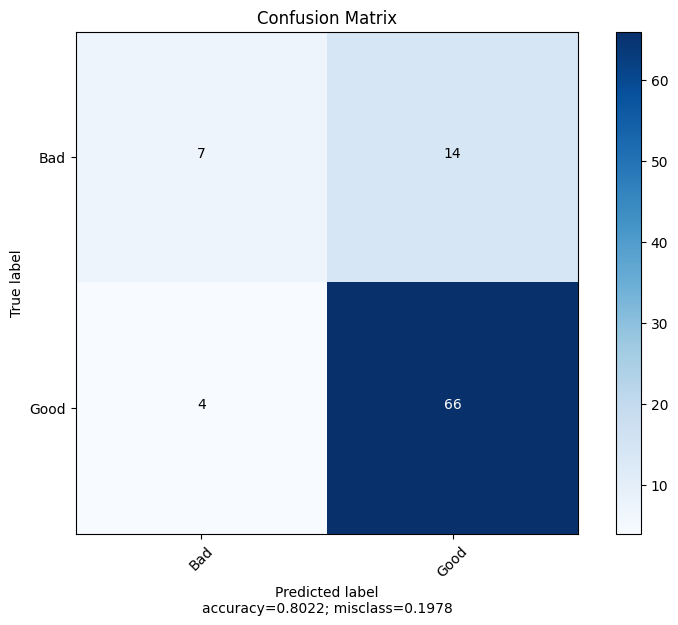

In [ ]:
plot_confusion_matrix(cm           = confusion_matrix(y_test, pred_log_reg),
                      normalize    = False,
                      target_names = ['Bad', 'Good'],
                      title        = "Confusion Matrix")

**Support Vector Classifier**

In [ ]:
## Logistic Regression
print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       1.00      0.29      0.44        21
           1       0.82      1.00      0.90        70

    accuracy                           0.84        91
   macro avg       0.91      0.64      0.67        91
weighted avg       0.86      0.84      0.80        91



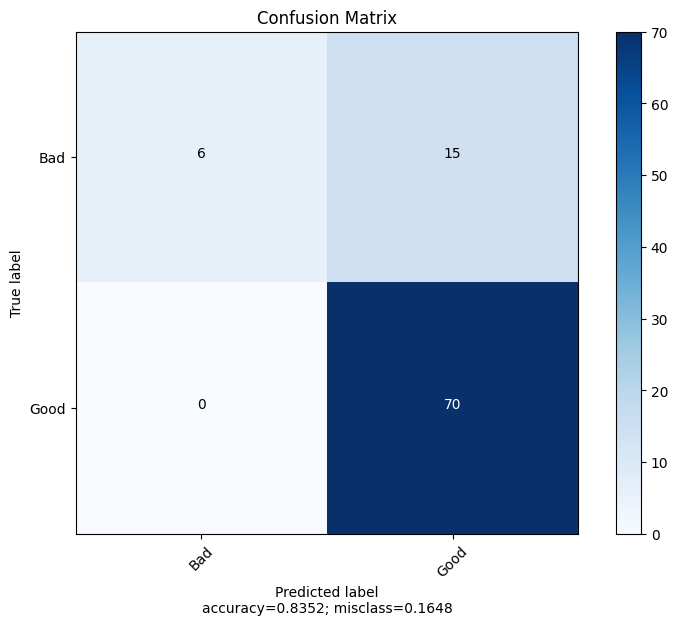

In [ ]:
plot_confusion_matrix(cm = confusion_matrix(y_test, pred_svc),
                      normalize    = False,
                      target_names = ['Bad', 'Good'],
                      title        = "Confusion Matrix")

In [ ]:
import joblib

# Your model's name and path, oh so dear,
model_name = "model.joblib"

# Saving it with Joblib's gentle hand,
joblib.dump(model_log_reg, model_name)

['model.joblib']

In [ ]:
import sklearn

print(sklearn.__version__)

1.4.2


In [ ]:
!pip install scikit-learn==1.4.2